# Tweet Sentiment Analysis

This notebook performs sentiment analysis on Elon Musk's tweets using:
1. **VADER** - General social media sentiment analyzer
2. **FinBERT** - Finance-specific BERT model for sentiment

Additionally, tweets are classified by market timing:
- **Pre-market**: 04:00-09:30 EST
- **Market hours**: 09:30-16:00 EST
- **After-market**: 16:00-20:00 EST
- **Off-hours**: 20:00-04:00 EST

## Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Figure size
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load Data

In [4]:
# Load sanitized tweet data
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data' / 'sanitized'

df_tweets = pd.read_csv(DATA_DIR / 'all_musk_posts_sanitized.csv')
df_tweets['createdAt'] = pd.to_datetime(df_tweets['createdAt'], utc=True)

print(f"Loaded {len(df_tweets):,} tweets")
print(f"Date range: {df_tweets['createdAt'].min()} to {df_tweets['createdAt'].max()}")

# Show sample
df_tweets[['createdAt', 'fullText', 'likeCount', 'retweetCount']].head()

Loaded 55,099 tweets
Date range: 2010-06-04 18:31:57+00:00 to 2025-04-13 21:28:44+00:00


,createdAt,fullText,likeCount,retweetCount
0,2010-06-04 18:31:57+00:00,"Please ignore prior tweets, as that was someon...",6392.0,697.0
1,2011-12-01 09:55:11+00:00,Went to Iceland on Sat to ride bumper cars on ...,197.0,27.0
2,2011-12-01 10:29:04+00:00,I made the volume on the Model S http://t.co/w...,124.0,19.0
3,2011-12-03 08:20:28+00:00,"Great Voltaire quote, arguably better than Twa...",87.0,36.0
4,2011-12-03 08:22:07+00:00,That was a total non sequitur btw,133.0,12.0


## Part 1: Market Timing Classification

Classify tweets based on when they were posted relative to US stock market hours (Eastern Time).

In [5]:
# Convert to Eastern Time for market classification
df_tweets['createdAt_ET'] = df_tweets['createdAt'].dt.tz_convert('America/New_York')
df_tweets['hour_ET'] = df_tweets['createdAt_ET'].dt.hour
df_tweets['minute_ET'] = df_tweets['createdAt_ET'].dt.minute
df_tweets['time_ET'] = df_tweets['createdAt_ET'].dt.time

# Define market timing function
def classify_market_timing(row):
    hour = row['hour_ET']
    minute = row['minute_ET']
    
    # Pre-market: 04:00-09:30 EST
    if (hour == 4 and minute >= 0) or (4 < hour < 9) or (hour == 9 and minute < 30):
        return 'Pre-market'
    # Market hours: 09:30-16:00 EST
    elif (hour == 9 and minute >= 30) or (9 < hour < 16):
        return 'Market hours'
    # After-market: 16:00-20:00 EST
    elif 16 <= hour < 20:
        return 'After-market'
    # Off-hours: 20:00-04:00 EST
    else:
        return 'Off-hours'

df_tweets['market_timing'] = df_tweets.apply(classify_market_timing, axis=1)

print("\nMarket timing classification completed!")
print("\nTweet distribution by market timing:")
print(df_tweets['market_timing'].value_counts().sort_index())
print("\nPercentage distribution:")
print((df_tweets['market_timing'].value_counts(normalize=True) * 100).round(2).sort_index())


Market timing classification completed!

Tweet distribution by market timing:
market_timing
After-market    10827
Market hours    17883
Off-hours       20583
Pre-market       5806
Name: count, dtype: int64

Percentage distribution:
market_timing
After-market    19.65
Market hours    32.46
Off-hours       37.36
Pre-market      10.54
Name: proportion, dtype: float64


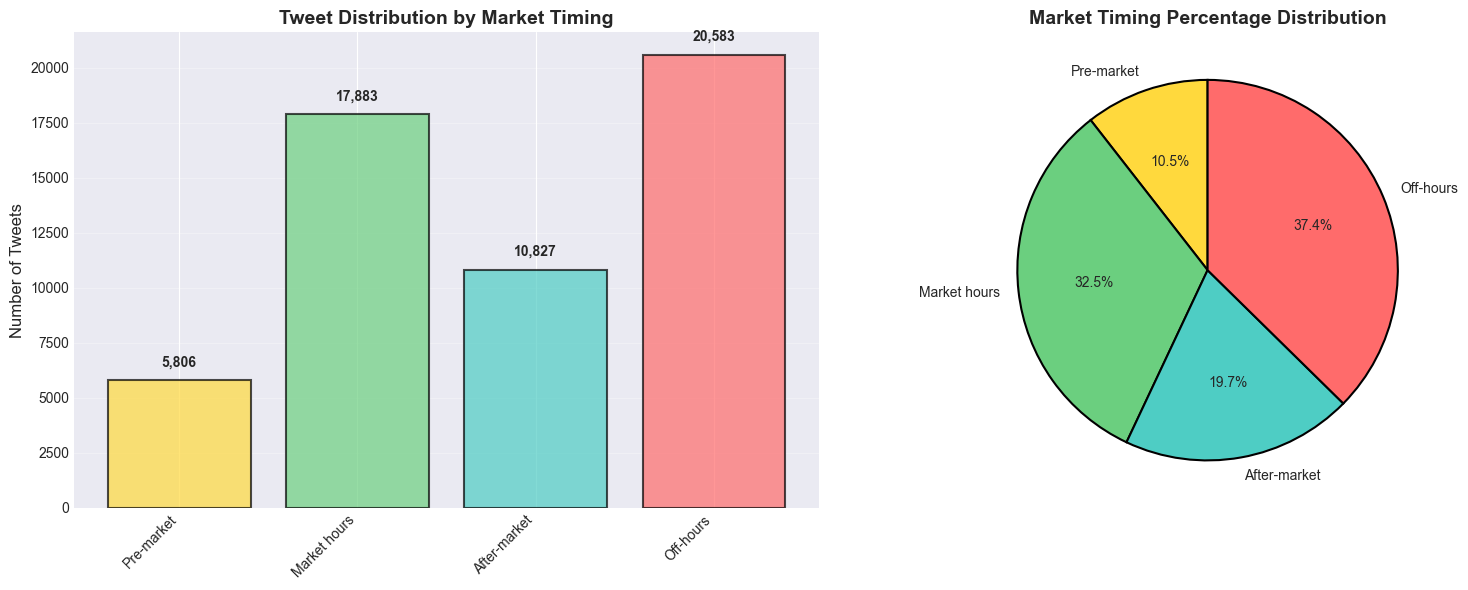

In [16]:
# Visualize market timing distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
timing_counts = df_tweets['market_timing'].value_counts()
timing_order = ['Pre-market', 'Market hours', 'After-market', 'Off-hours']
colors_map = {'Pre-market': '#FFD93D', 'Market hours': '#6BCF7F', 
              'After-market': '#4ECDC4', 'Off-hours': '#FF6B6B'}
colors = [colors_map[t] for t in timing_order]

axes[0].bar(range(len(timing_order)), 
            [timing_counts.get(t, 0) for t in timing_order],
            color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(timing_order)))
axes[0].set_xticklabels(timing_order, rotation=45, ha='right')
axes[0].set_ylabel('Number of Tweets', fontsize=12)
axes[0].set_title('Tweet Distribution by Market Timing', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, count in enumerate([timing_counts.get(t, 0) for t in timing_order]):
    axes[0].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pie chart
axes[1].pie([timing_counts.get(t, 0) for t in timing_order], 
            labels=timing_order, autopct='%1.1f%%',
            colors=colors, startangle=90, 
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].set_title('Market Timing Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Part 2: VADER Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is optimized for social media text.

In [17]:
# Initialize VADER
vader_analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment with VADER
def analyze_vader_sentiment(text):
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    scores = vader_analyzer.polarity_scores(str(text))
    return scores

# Apply VADER sentiment analysis
print("Analyzing sentiment with VADER...")
print("This may take a few minutes...")

vader_scores = df_tweets['fullText'].apply(analyze_vader_sentiment)
df_tweets['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
df_tweets['vader_neu'] = vader_scores.apply(lambda x: x['neu'])
df_tweets['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
df_tweets['vader_compound'] = vader_scores.apply(lambda x: x['compound'])

# Classify sentiment based on compound score
def classify_vader_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_tweets['vader_sentiment'] = df_tweets['vader_compound'].apply(classify_vader_sentiment)

print("\nVADER sentiment analysis completed!")
print("\nSentiment distribution:")
print(df_tweets['vader_sentiment'].value_counts())
print("\nPercentage distribution:")
print((df_tweets['vader_sentiment'].value_counts(normalize=True) * 100).round(2))

Analyzing sentiment with VADER...
This may take a few minutes...



VADER sentiment analysis completed!

Sentiment distribution:
vader_sentiment
Positive    26181
Neutral     19577
Negative     9341
Name: count, dtype: int64

Percentage distribution:
vader_sentiment
Positive    47.52
Neutral     35.53
Negative    16.95
Name: proportion, dtype: float64


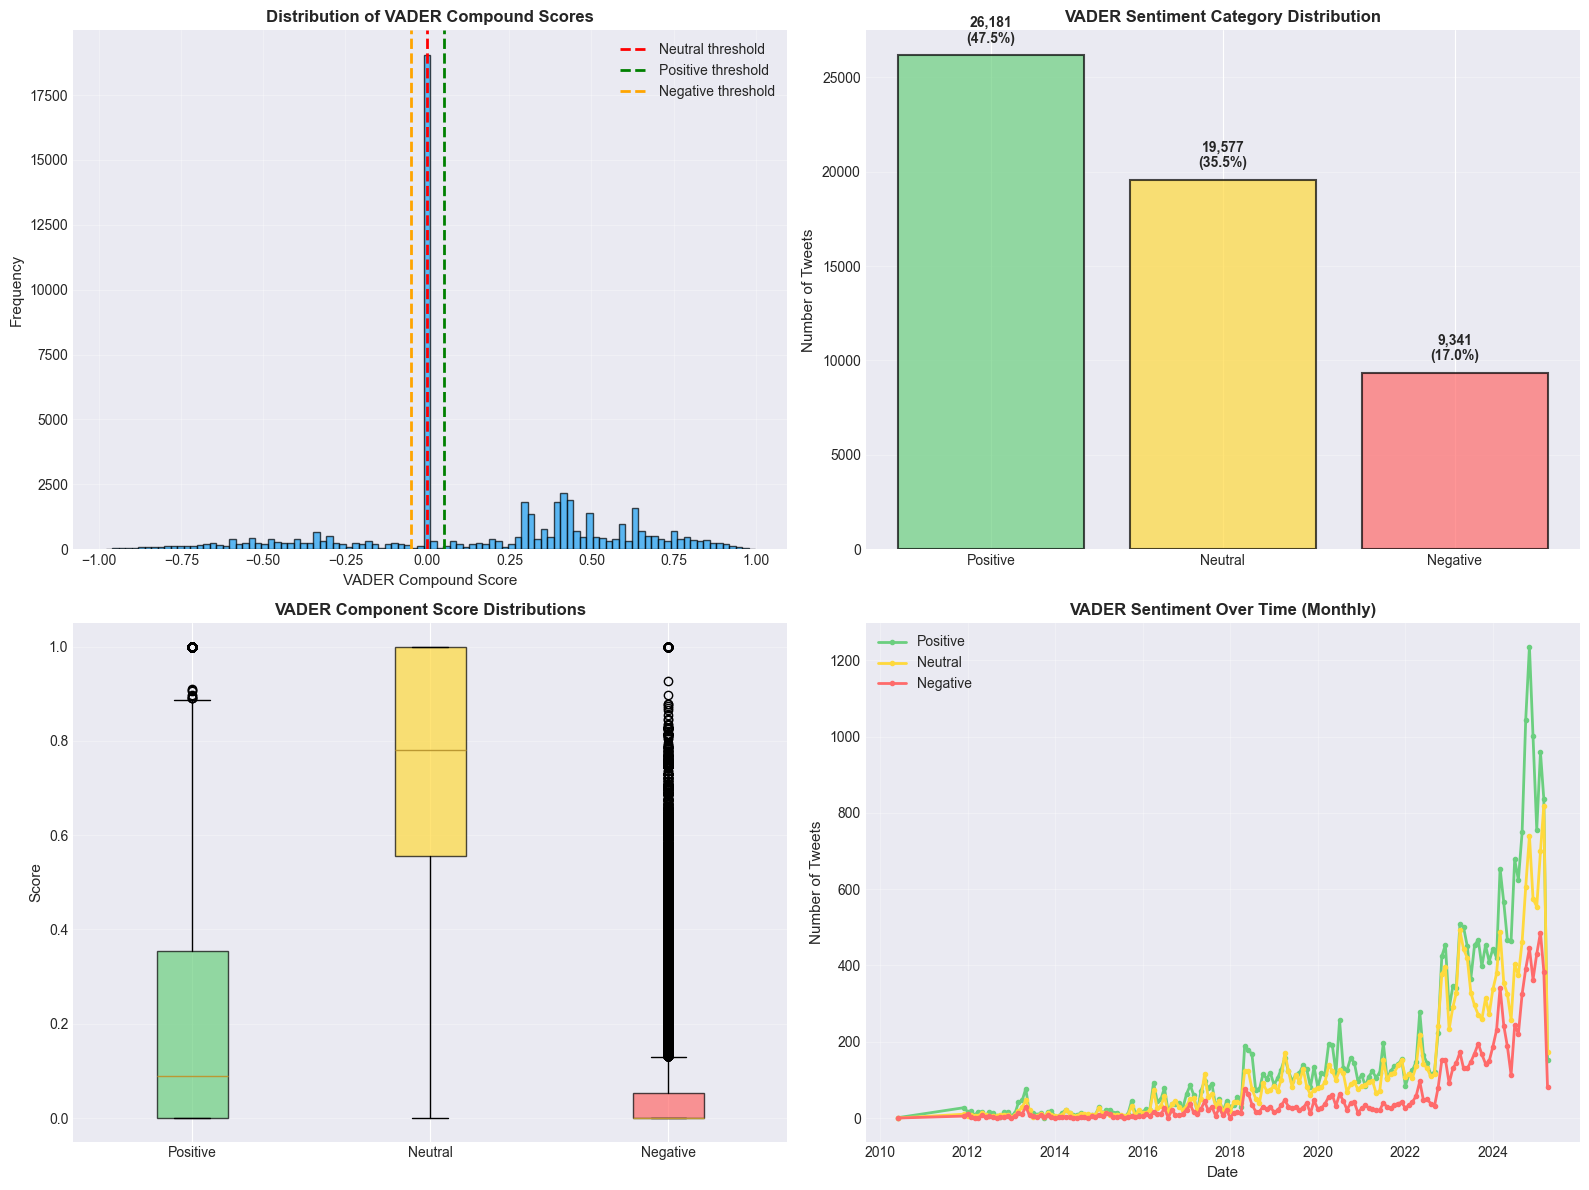

In [18]:
# Visualize VADER sentiment distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Compound score distribution
axes[0, 0].hist(df_tweets['vader_compound'], bins=100, 
                color='#1DA1F2', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral threshold')
axes[0, 0].axvline(0.05, color='green', linestyle='--', linewidth=2, label='Positive threshold')
axes[0, 0].axvline(-0.05, color='orange', linestyle='--', linewidth=2, label='Negative threshold')
axes[0, 0].set_xlabel('VADER Compound Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of VADER Compound Scores', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Sentiment category distribution
sentiment_counts = df_tweets['vader_sentiment'].value_counts()
sentiment_colors = {'Positive': '#6BCF7F', 'Neutral': '#FFD93D', 'Negative': '#FF6B6B'}
colors = [sentiment_colors[s] for s in sentiment_counts.index]

axes[0, 1].bar(range(len(sentiment_counts)), sentiment_counts.values,
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(sentiment_counts)))
axes[0, 1].set_xticklabels(sentiment_counts.index)
axes[0, 1].set_ylabel('Number of Tweets', fontsize=11)
axes[0, 1].set_title('VADER Sentiment Category Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, count in enumerate(sentiment_counts.values):
    axes[0, 1].text(i, count + 500, f'{count:,}\n({count/len(df_tweets)*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Positive/Negative/Neutral component distributions
component_data = df_tweets[['vader_pos', 'vader_neu', 'vader_neg']]
bp = axes[1, 0].boxplot([component_data['vader_pos'], component_data['vader_neu'], component_data['vader_neg']],
                        labels=['Positive', 'Neutral', 'Negative'],
                        patch_artist=True)
for patch, color in zip(bp['boxes'], ['#6BCF7F', '#FFD93D', '#FF6B6B']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('VADER Component Score Distributions', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Sentiment over time
df_tweets['year_month'] = df_tweets['createdAt'].dt.to_period('M').dt.to_timestamp()
monthly_sentiment = df_tweets.groupby(['year_month', 'vader_sentiment']).size().unstack(fill_value=0)

if 'Positive' in monthly_sentiment.columns:
    axes[1, 1].plot(monthly_sentiment.index, monthly_sentiment['Positive'], 
                    label='Positive', color='#6BCF7F', linewidth=2, marker='o', markersize=3)
if 'Neutral' in monthly_sentiment.columns:
    axes[1, 1].plot(monthly_sentiment.index, monthly_sentiment['Neutral'], 
                    label='Neutral', color='#FFD93D', linewidth=2, marker='o', markersize=3)
if 'Negative' in monthly_sentiment.columns:
    axes[1, 1].plot(monthly_sentiment.index, monthly_sentiment['Negative'], 
                    label='Negative', color='#FF6B6B', linewidth=2, marker='o', markersize=3)

axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].set_ylabel('Number of Tweets', fontsize=11)
axes[1, 1].set_title('VADER Sentiment Over Time (Monthly)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: FinBERT Sentiment Analysis

FinBERT is a BERT model fine-tuned on financial text for sentiment analysis.

In [19]:
# Load FinBERT model and tokenizer
print("Loading FinBERT model...")
print("This may take a few minutes on first run...")

finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_pipeline = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer)

print("FinBERT model loaded successfully!")

Loading FinBERT model...
This may take a few minutes on first run...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 2215.39it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


FinBERT model loaded successfully!


In [10]:
# Function to analyze sentiment with FinBERT (with batching for efficiency)
def analyze_finbert_sentiment_batch(texts, batch_size=32):
    results = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Clean and truncate texts
        batch_cleaned = [str(text)[:512] if pd.notna(text) else "" for text in batch]
        
        try:
            batch_results = finbert_pipeline(batch_cleaned, truncation=True, max_length=512)
            results.extend(batch_results)
        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
            # Add empty results for failed batch
            results.extend([{'label': 'neutral', 'score': 0.0}] * len(batch))
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch):,} / {len(texts):,} tweets...")
    
    return results

# Analyze sentiment with FinBERT
print("\nAnalyzing sentiment with FinBERT...")
print("This will take several minutes depending on dataset size...")
print("Note: Processing a sample for demonstration purposes\n")

# For demonstration, process a sample (can change to full dataset)
SAMPLE_SIZE = 5000  # Adjust this value (set to len(df_tweets) for full analysis)
sample_indices = df_tweets.sample(min(SAMPLE_SIZE, len(df_tweets)), random_state=42).index

finbert_results = analyze_finbert_sentiment_batch(df_tweets.loc[sample_indices, 'fullText'].tolist())

# Create a results dataframe
df_finbert = pd.DataFrame(finbert_results)
df_finbert.index = sample_indices

# Add results to main dataframe
df_tweets.loc[sample_indices, 'finbert_sentiment'] = df_finbert['label']
df_tweets.loc[sample_indices, 'finbert_score'] = df_finbert['score']

print("\nFinBERT sentiment analysis completed!")
print(f"\nAnalyzed {len(sample_indices):,} tweets")
print("\nSentiment distribution (FinBERT):")
print(df_tweets.loc[sample_indices, 'finbert_sentiment'].value_counts())
print("\nPercentage distribution:")
print((df_tweets.loc[sample_indices, 'finbert_sentiment'].value_counts(normalize=True) * 100).round(2))


Analyzing sentiment with FinBERT...
This will take several minutes depending on dataset size...
Note: Processing a sample for demonstration purposes

Processed 320 / 5,000 tweets...
Processed 640 / 5,000 tweets...
Processed 960 / 5,000 tweets...
Processed 1,280 / 5,000 tweets...
Processed 1,600 / 5,000 tweets...
Processed 1,920 / 5,000 tweets...
Processed 2,240 / 5,000 tweets...
Processed 2,560 / 5,000 tweets...
Processed 2,880 / 5,000 tweets...
Processed 3,200 / 5,000 tweets...
Processed 3,520 / 5,000 tweets...
Processed 3,840 / 5,000 tweets...
Processed 4,160 / 5,000 tweets...
Processed 4,480 / 5,000 tweets...
Processed 4,800 / 5,000 tweets...

FinBERT sentiment analysis completed!

Analyzed 5,000 tweets

Sentiment distribution (FinBERT):
finbert_sentiment
neutral     4344
negative     415
positive     241
Name: count, dtype: int64

Percentage distribution:
finbert_sentiment
neutral     86.88
negative     8.30
positive     4.82
Name: proportion, dtype: float64


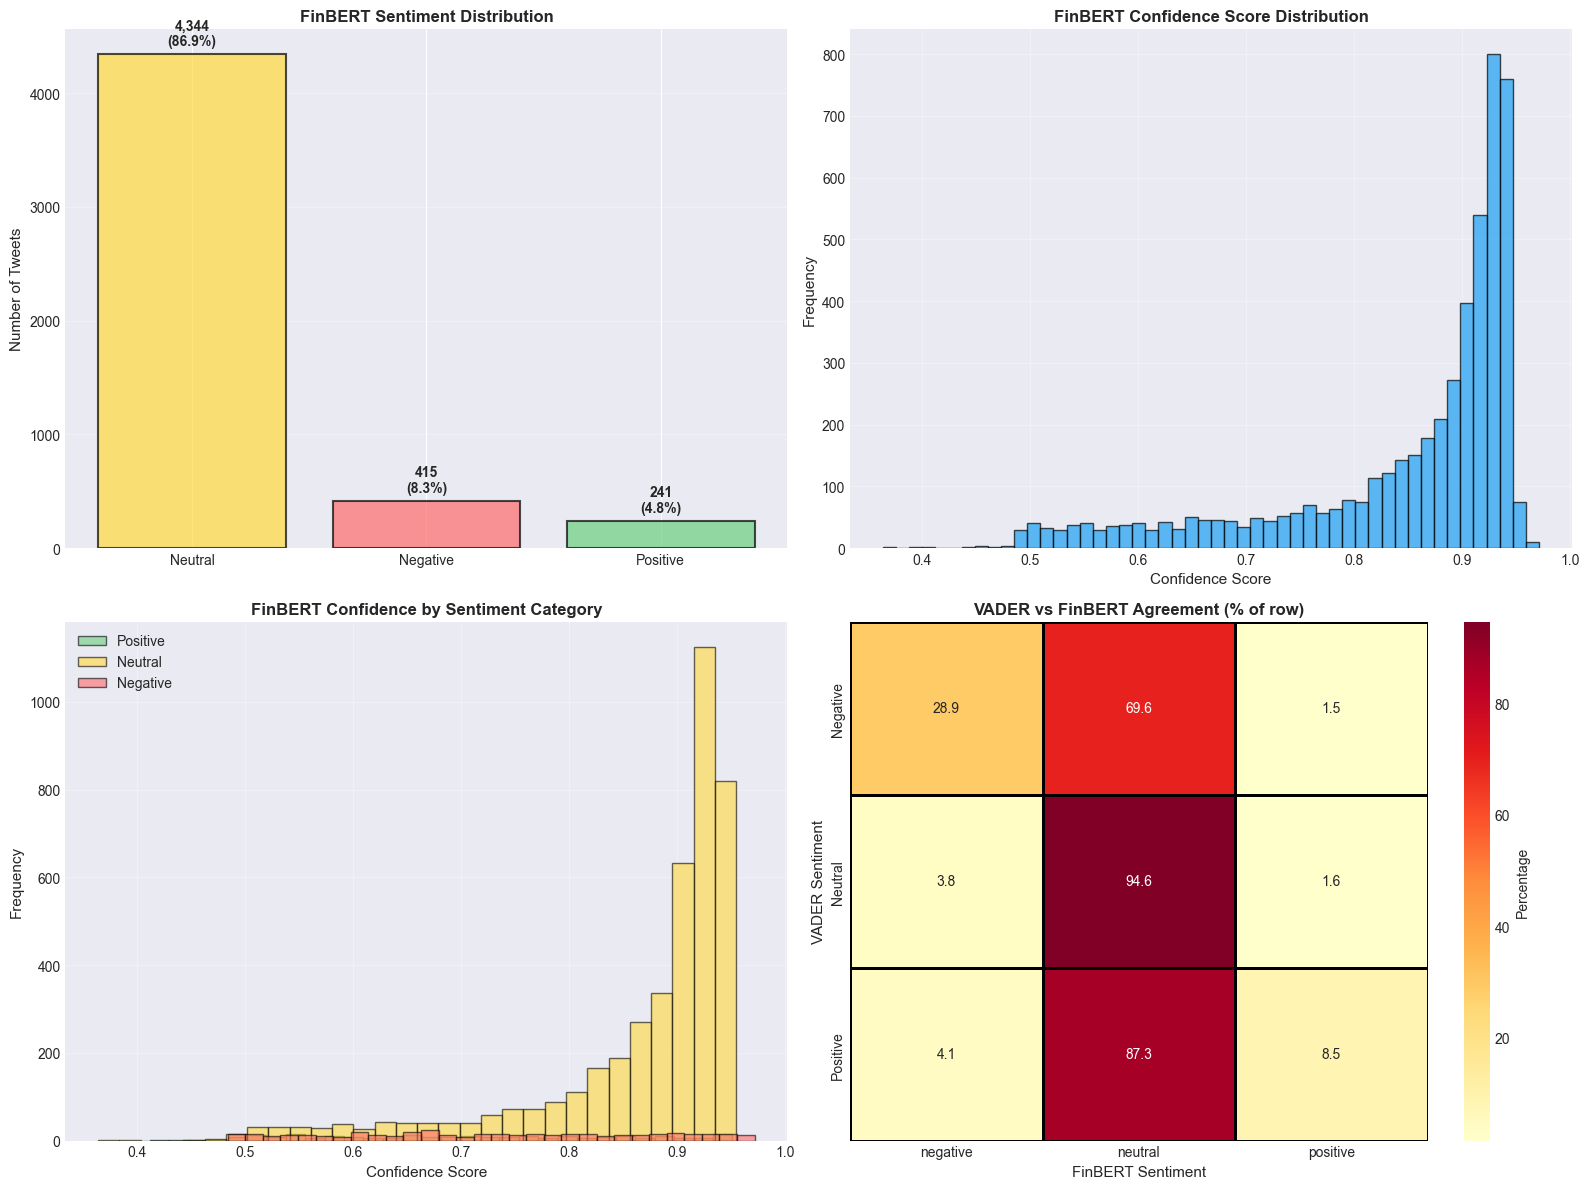


VADER-FinBERT Agreement: 42.96%


In [11]:
# Visualize FinBERT sentiment results
df_sample = df_tweets.loc[sample_indices].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sentiment distribution
finbert_counts = df_sample['finbert_sentiment'].value_counts()
finbert_colors = {'positive': '#6BCF7F', 'neutral': '#FFD93D', 'negative': '#FF6B6B'}
colors = [finbert_colors.get(s, '#CCCCCC') for s in finbert_counts.index]

axes[0, 0].bar(range(len(finbert_counts)), finbert_counts.values,
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(finbert_counts)))
axes[0, 0].set_xticklabels([s.capitalize() for s in finbert_counts.index])
axes[0, 0].set_ylabel('Number of Tweets', fontsize=11)
axes[0, 0].set_title('FinBERT Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(finbert_counts.values):
    axes[0, 0].text(i, count + 50, f'{count:,}\n({count/len(df_sample)*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Confidence score distribution
axes[0, 1].hist(df_sample['finbert_score'], bins=50, 
                color='#1DA1F2', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Confidence Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('FinBERT Confidence Score Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Confidence by sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    if sentiment in df_sample['finbert_sentiment'].values:
        data = df_sample[df_sample['finbert_sentiment'] == sentiment]['finbert_score']
        axes[1, 0].hist(data, bins=30, alpha=0.6, 
                       label=sentiment.capitalize(), 
                       color=finbert_colors.get(sentiment, '#CCCCCC'),
                       edgecolor='black')

axes[1, 0].set_xlabel('Confidence Score', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('FinBERT Confidence by Sentiment Category', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparison: VADER vs FinBERT (for sample)
comparison = pd.crosstab(df_sample['vader_sentiment'], 
                         df_sample['finbert_sentiment'],
                         normalize='index') * 100

sns.heatmap(comparison, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage'}, ax=axes[1, 1],
            linewidths=1, linecolor='black')
axes[1, 1].set_xlabel('FinBERT Sentiment', fontsize=11)
axes[1, 1].set_ylabel('VADER Sentiment', fontsize=11)
axes[1, 1].set_title('VADER vs FinBERT Agreement (% of row)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate agreement
vader_map = {'Positive': 'positive', 'Neutral': 'neutral', 'Negative': 'negative'}
df_sample['vader_mapped'] = df_sample['vader_sentiment'].map(vader_map)
agreement = (df_sample['vader_mapped'] == df_sample['finbert_sentiment']).sum() / len(df_sample) * 100
print(f"\nVADER-FinBERT Agreement: {agreement:.2f}%")

## Part 4: Cross-Categorical Analysis

Compare sentiment across market timing categories.

In [12]:
# Sentiment by market timing (VADER)
print("=" * 80)
print("VADER SENTIMENT BY MARKET TIMING")
print("=" * 80)

timing_sentiment_vader = pd.crosstab(df_tweets['market_timing'], 
                                      df_tweets['vader_sentiment'],
                                      margins=True)
print("\nCount:")
print(timing_sentiment_vader)

print("\nPercentage (by row):")
timing_sentiment_vader_pct = pd.crosstab(df_tweets['market_timing'], 
                                          df_tweets['vader_sentiment'],
                                          normalize='index') * 100
print(timing_sentiment_vader_pct.round(2))

# Average compound score by timing
print("\nAverage VADER Compound Score by Market Timing:")
avg_compound = df_tweets.groupby('market_timing')['vader_compound'].mean().sort_index()
print(avg_compound.round(4))

VADER SENTIMENT BY MARKET TIMING

Count:
vader_sentiment  Negative  Neutral  Positive    All
market_timing                                      
After-market         1764     3831      5232  10827
Market hours         3260     5933      8690  17883
Off-hours            3307     7652      9624  20583
Pre-market           1010     2161      2635   5806
All                  9341    19577     26181  55099

Percentage (by row):
vader_sentiment  Negative  Neutral  Positive
market_timing                               
After-market        16.29    35.38     48.32
Market hours        18.23    33.18     48.59
Off-hours           16.07    37.18     46.76
Pre-market          17.40    37.22     45.38

Average VADER Compound Score by Market Timing:
market_timing
After-market    0.1693
Market hours    0.1589
Off-hours       0.1581
Pre-market      0.1408
Name: vader_compound, dtype: float64


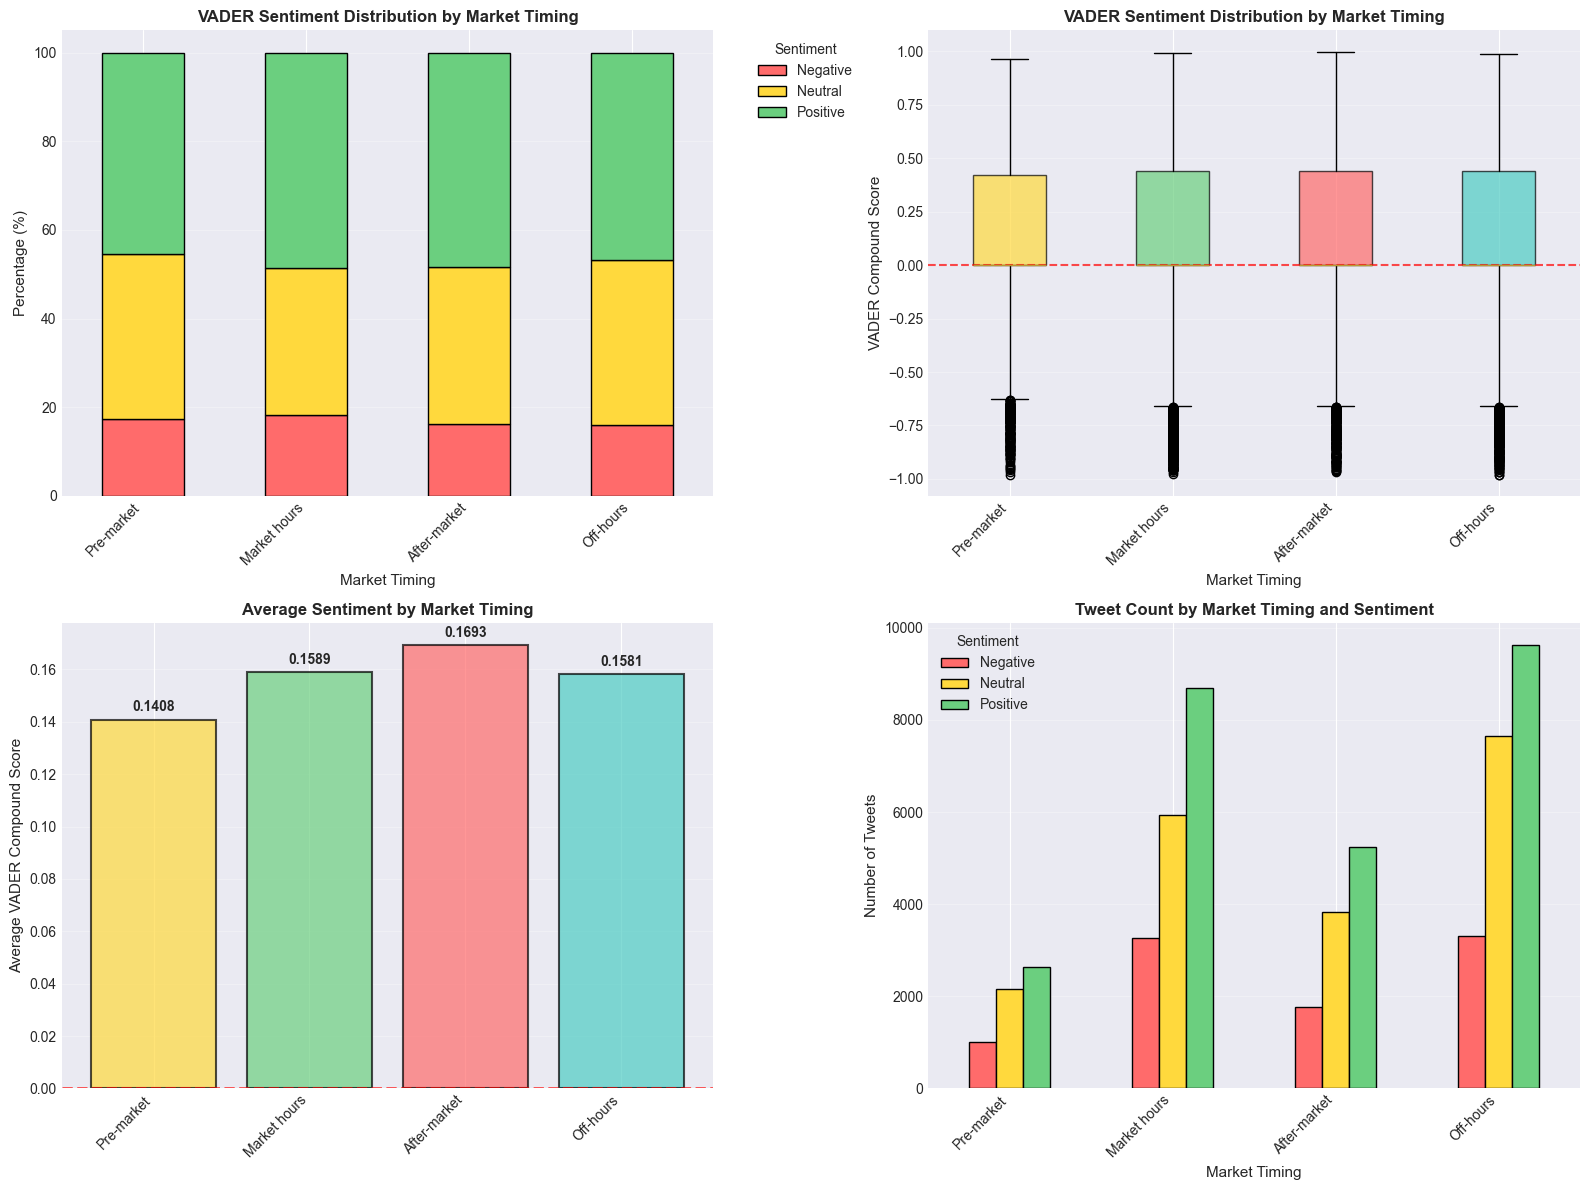

In [13]:
# Visualize sentiment across market timing
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stacked bar chart - VADER sentiment by market timing
timing_order = ['Pre-market', 'Market hours', 'After-market', 'Off-hours']
sentiment_data = pd.crosstab(df_tweets['market_timing'], 
                             df_tweets['vader_sentiment'],
                             normalize='index') * 100
sentiment_data = sentiment_data.reindex(timing_order)

sentiment_data.plot(kind='bar', stacked=True, ax=axes[0, 0],
                   color=['#FF6B6B', '#FFD93D', '#6BCF7F'],
                   edgecolor='black', linewidth=1)
axes[0, 0].set_xlabel('Market Timing', fontsize=11)
axes[0, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 0].set_title('VADER Sentiment Distribution by Market Timing', fontsize=12, fontweight='bold')
axes[0, 0].set_xticklabels(timing_order, rotation=45, ha='right')
axes[0, 0].legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Box plot - VADER compound scores by market timing
timing_data = [df_tweets[df_tweets['market_timing'] == timing]['vader_compound'].values 
               for timing in timing_order]

bp = axes[0, 1].boxplot(timing_data, labels=timing_order, patch_artist=True)
timing_colors_map = {'Pre-market': '#FFD93D', 'Market hours': '#6BCF7F', 
                     'After-market': '#FF6B6B', 'Off-hours': '#4ECDC4'}
for patch, timing in zip(bp['boxes'], timing_order):
    patch.set_facecolor(timing_colors_map[timing])
    patch.set_alpha(0.7)

axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0, 1].set_xlabel('Market Timing', fontsize=11)
axes[0, 1].set_ylabel('VADER Compound Score', fontsize=11)
axes[0, 1].set_title('VADER Sentiment Distribution by Market Timing', fontsize=12, fontweight='bold')
axes[0, 1].set_xticklabels(timing_order, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average sentiment scores by timing
avg_scores = df_tweets.groupby('market_timing')['vader_compound'].mean().reindex(timing_order)
colors = [timing_colors_map[t] for t in timing_order]

axes[1, 0].bar(range(len(timing_order)), avg_scores.values,
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].set_xticks(range(len(timing_order)))
axes[1, 0].set_xticklabels(timing_order, rotation=45, ha='right')
axes[1, 0].set_ylabel('Average VADER Compound Score', fontsize=11)
axes[1, 0].set_title('Average Sentiment by Market Timing', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, score in enumerate(avg_scores.values):
    axes[1, 0].text(i, score + 0.002 if score > 0 else score - 0.002, 
                    f'{score:.4f}', ha='center', 
                    va='bottom' if score > 0 else 'top', 
                    fontsize=10, fontweight='bold')

# Tweet count by market timing and sentiment
count_data = pd.crosstab(df_tweets['market_timing'], df_tweets['vader_sentiment'])
count_data = count_data.reindex(timing_order)

count_data.plot(kind='bar', ax=axes[1, 1],
                color=['#FF6B6B', '#FFD93D', '#6BCF7F'],
                edgecolor='black', linewidth=1)
axes[1, 1].set_xlabel('Market Timing', fontsize=11)
axes[1, 1].set_ylabel('Number of Tweets', fontsize=11)
axes[1, 1].set_title('Tweet Count by Market Timing and Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(timing_order, rotation=45, ha='right')
axes[1, 1].legend(title='Sentiment')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Save Processed Data

In [14]:
# Save the sentiment-analyzed data
output_path = DATA_DIR / 'tweets_with_sentiment.csv'

# Select relevant columns
columns_to_save = ['id', 'createdAt', 'fullText', 'likeCount', 'retweetCount', 
                   'replyCount', 'quoteCount', 'viewCount',
                   'market_timing', 'hour_ET',
                   'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'vader_sentiment']

# Add FinBERT columns if they exist
if 'finbert_sentiment' in df_tweets.columns:
    columns_to_save.extend(['finbert_sentiment', 'finbert_score'])

df_tweets[columns_to_save].to_csv(output_path, index=False)

print(f"\nSentiment-analyzed data saved to: {output_path}")
print(f"Total tweets: {len(df_tweets):,}")
print(f"Columns saved: {len(columns_to_save)}")


Sentiment-analyzed data saved to: /Users/albertang/Documents/GitHub/tweet-driven-market-reactions/data/sanitized/tweets_with_sentiment.csv
Total tweets: 55,099
Columns saved: 17


## Summary Statistics

In [15]:
print("=" * 80)
print("SENTIMENT ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nTotal tweets analyzed: {len(df_tweets):,}")

print("\n" + "=" * 80)
print("VADER SENTIMENT")
print("=" * 80)
print("\nDistribution:")
for sentiment, count in df_tweets['vader_sentiment'].value_counts().items():
    pct = count / len(df_tweets) * 100
    print(f"  {sentiment}: {count:,} ({pct:.2f}%)")

print(f"\nAverage compound score: {df_tweets['vader_compound'].mean():.4f}")
print(f"Median compound score: {df_tweets['vader_compound'].median():.4f}")
print(f"Std dev compound score: {df_tweets['vader_compound'].std():.4f}")

if 'finbert_sentiment' in df_tweets.columns:
    analyzed_count = df_tweets['finbert_sentiment'].notna().sum()
    print("\n" + "=" * 80)
    print("FINBERT SENTIMENT")
    print("=" * 80)
    print(f"\nTweets analyzed: {analyzed_count:,}")
    print("\nDistribution:")
    for sentiment, count in df_tweets['finbert_sentiment'].value_counts().items():
        pct = count / analyzed_count * 100
        print(f"  {sentiment}: {count:,} ({pct:.2f}%)")
    
    print(f"\nAverage confidence score: {df_tweets['finbert_score'].mean():.4f}")

print("\n" + "=" * 80)
print("MARKET TIMING")
print("=" * 80)
print("\nDistribution:")
for timing, count in df_tweets['market_timing'].value_counts().sort_index().items():
    pct = count / len(df_tweets) * 100
    print(f"  {timing}: {count:,} ({pct:.2f}%)")

print("\n" + "=" * 80)
print("SENTIMENT BY MARKET TIMING (VADER)")
print("=" * 80)
for timing in ['Pre-market', 'Market hours', 'After-market', 'Off-hours']:
    timing_data = df_tweets[df_tweets['market_timing'] == timing]
    avg_compound = timing_data['vader_compound'].mean()
    pos_pct = (timing_data['vader_sentiment'] == 'Positive').sum() / len(timing_data) * 100
    print(f"\n{timing}:")
    print(f"  Avg compound: {avg_compound:.4f}")
    print(f"  Positive tweets: {pos_pct:.2f}%")

print("\n" + "=" * 80)

SENTIMENT ANALYSIS SUMMARY

Total tweets analyzed: 55,099

VADER SENTIMENT

Distribution:
  Positive: 26,181 (47.52%)
  Neutral: 19,577 (35.53%)
  Negative: 9,341 (16.95%)

Average compound score: 0.1587
Median compound score: 0.0000
Std dev compound score: 0.3823

FINBERT SENTIMENT

Tweets analyzed: 5,000

Distribution:
  neutral: 4,344 (86.88%)
  negative: 415 (8.30%)
  positive: 241 (4.82%)

Average confidence score: 0.8489

MARKET TIMING

Distribution:
  After-market: 10,827 (19.65%)
  Market hours: 17,883 (32.46%)
  Off-hours: 20,583 (37.36%)
  Pre-market: 5,806 (10.54%)

SENTIMENT BY MARKET TIMING (VADER)

Pre-market:
  Avg compound: 0.1408
  Positive tweets: 45.38%

Market hours:
  Avg compound: 0.1589
  Positive tweets: 48.59%

After-market:
  Avg compound: 0.1693
  Positive tweets: 48.32%

Off-hours:
  Avg compound: 0.1581
  Positive tweets: 46.76%

